# Autoencoder v2
## Details:
1. 6 layers each in encoder and decoder (3 Conv3d, 3 MaxPooling3D)
2. Dataset - 1000 STL files
3. Train - 800 models
4. Test - 200 models

### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Flatten, Reshape
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-10-24 11:19:28.482038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 11:19:28.482116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 11:19:28.487342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 11:19:29.193930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])[:1000]
dataset = []

In [3]:
for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path)
    dataset.append(binvox)

### Splitting dataset for training and testing

In [4]:
dataset = np.array(dataset)
num = int(1000*0.8)

In [5]:
# Load your dataset into numpy arrays
# Here we are using 800 models in train dataset, and 200 in test dataset
# Split your dataset into train and test datasets
train_dataset = dataset[:num]  # Adjust the number as needed
test_dataset = dataset[num:]   # The remaining data for testing
# Define the input shape
input_shape = (64, 64, 64, 1)

### Encoder

In [6]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

2023-10-24 11:20:41.445562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 11:20:42.265945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 11:20:42.266624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Decoder

In [7]:
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Training autoencoder, prediction done on test dataset

In [8]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=40, batch_size=10, validation_data=(test_dataset, test_dataset))

2023-10-24 11:20:50.377000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-24 11:20:51.356204: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-24 11:20:52.033676: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-24 11:20:52.160574: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.


Epoch 1/40


2023-10-24 11:20:54.720286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-24 11:21:05.098840: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3808f6f780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 11:21:05.098872: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-24 11:21:05.208009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-24 11:21:05.548857: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 40s 306ms/step - loss: 0.3227 - val_loss: 0.1835
Epoch 2/40
80/80 [==============================] - 24s 296ms/step - loss: 0.0832 - val_loss: 0.0642
Epoch 3/40
80/80 [==============================] - 24s 297ms/step - loss: 0.0607 - val_loss: 0.0599
Epoch 4/40
80/80 [==============================] - 24s 299ms/step - loss: 0.0576 - val_loss: 0.0579
Epoch 5/40
80/80 [==============================] - 24s 298ms/step - loss: 0.0555 - val_loss: 0.0559
Epoch 6/40
80/80 [==============================] - 24s 298ms/step - loss: 0.0537 - val_loss: 0.0551
Epoch 7/40
80/80 [==============================] - 24s 299ms/step - loss: 0.0529 - val_loss: 0.0532
Epoch 8/40
80/80 [==============================] - 24s 299ms/step - loss: 0.0515 - val_loss: 0.0522
Epoch 9/40
80/80 [==============================] - 24s 299ms/step - loss: 0.0508 - val_loss: 0.0519
Epoch 10/40
80/80 [==============================] - 24s 299ms/step - loss: 0.0495 - val_loss: 0.0506


In [9]:
reconstructed_data = autoencoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 2s 87ms/step


In [10]:
encoder = Model(inputs=input_data, outputs=encoded)
encoded_data = encoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 1s 30ms/step


#### Dimensions

In [16]:
print(test_dataset[0].shape)
print(encoded_data[0].shape)
print(reconstructed_data[0].shape)

(64, 64, 64)
(8, 8, 8, 8)
(64, 64, 64, 1)


In [49]:
# This will convert the encoded data of each model (which is of shape 8x8x8x8) to a 1D array of 4096 elements
encoded_data_flattened = encoded_data[0].flatten()
print(encoded_data_flattened.shape)
# This will convert the above array of 4096 elements back to the original encoder output of 8x8x8x8 dimensions (4D array)
encoded_regenerated = encoded_data_flattened.reshape(8, 8, 8, 8)
print(encoded_regenerated.shape)

(4096,)
(8, 8, 8, 8)


### Sample reconstruction from test dataset

In [38]:
import matplotlib.pyplot as plt

index = 25

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

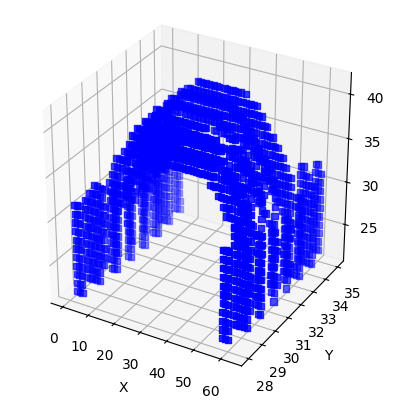

In [39]:
Visualization.matplotlib_visualize_original(original_sample)

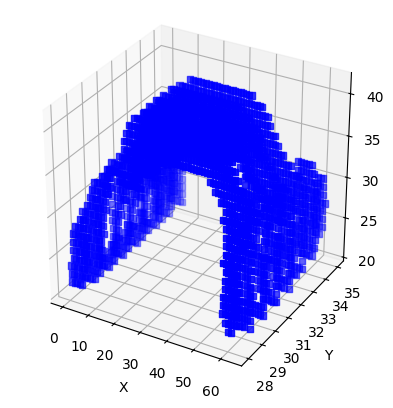

In [40]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [44]:
Visualization.open3d_visualize_original(original_sample)

In [45]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)